## Super Mario Maker Dataset - Recommender System

### 1. Prerequisites

Import required libraries.

In [1]:
#!pip install surprise

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import os
import gc
from sklearn import model_selection
from surprise import NormalPredictor, SVD, KNNBasic, SVDpp
from surprise import Dataset
from surprise import Reader
import surprise
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate

import scipy
from scipy.sparse import csr_matrix


Specify data files location.

In [2]:
data_path = '/Users/pj/Documents/671_Project/'

Read data of games played.

In [3]:
plays_df = pd.read_csv(data_path + 'plays.csv', sep="\t", usecols=['id', 'player'])
plays_df.columns = ['game', 'player']

In [4]:
plays_df.head()

,game,player
0,0000-0000-0353-3D35,darter60k
1,0000-0000-0353-3D35,davidchofis
2,0000-0000-0353-3D35,fabioviana
3,0000-0000-0353-3D35,gorigokky
4,0000-0000-0353-3D35,groebenzell


Add a column with value of 0 to start with indicating game is played but not cleared by the player.

In [5]:
plays_df['score'] = 0

Read data of games cleared data.

In [6]:
clears_df = pd.read_csv('/Users/pj/Documents/671_Project/clears.csv', sep='\t', usecols=['id', 'player'])
clears_df.columns = ['game', 'player']

In [7]:
clears_df.head()

,game,player
0,0000-0000-0353-3D35,darter60k
1,0000-0000-0353-3D35,davidchofis
2,0000-0000-0353-3D35,fabioviana
3,0000-0000-0353-3D35,groebenzell
4,0000-0000-0353-3D35,igatake0229


Add a column with value of 1 indicating that the game is cleared by the player.

In [8]:
clears_df['score'] = 1

In [9]:
plays_df.head()

,game,player,score
0,0000-0000-0353-3D35,darter60k,0
1,0000-0000-0353-3D35,davidchofis,0
2,0000-0000-0353-3D35,fabioviana,0
3,0000-0000-0353-3D35,gorigokky,0
4,0000-0000-0353-3D35,groebenzell,0


Next we merge the 2 dataframes, so it now has information about games cleared as well as games played, but not cleared.

In [10]:
all_data = clears_df.merge(plays_df, how='outer', on=['game', 'player'])

In [11]:
all_data.sample(5)

,game,player,score_x,score_y
1765852,DC84-0000-032C-80C9,MightyOBERON,1.0,0.0
2397648,2BC9-0000-0362-A24D,Noooo15,NaN,0.0
301831,2679-0000-032A-F74E,Kadezzoyt,1.0,0.0
789624,62E9-0000-0352-71C0,goatoo,1.0,0.0
3453745,B118-0000-031B-1E68,JOJOGIOGIO1119,NaN,0.0


Replace *NaN* values with $0$.

In [12]:
all_data.fillna(0, inplace=True)

Drop last column *score_y* as it contains only zeroes, all required information is now available in *score_x*. It is $0$ when the player has just played the game, but not cleared. It is $1$ when the player has cleared that game.

In [13]:
all_data.drop(columns='score_y', inplace=True)

Presently, $0$ and $1$ labels are segregated, lets shuffle the dataframe to distribute them.

In [14]:
all_data = all_data.sample(frac=1).reset_index(drop=True)

In [15]:
train_data, test_data = model_selection.train_test_split(all_data, test_size = 0.2)
val_data, test_data   = model_selection.train_test_split(test_data, test_size = 0.5)

### 2. Exploratory Data Analysis.

Let us check some data attributes before building the recommendation system.

In [16]:
print('Total number of players : {}'.format(len(all_data['player'].value_counts())))
print('Total number of games   : {}'.format(len(all_data['game'].value_counts())))

Total number of players : 861465
Total number of games   : 115032


In [17]:
print('Number of games played and cleared     : {}'.format(len(all_data[all_data['score_x'] == 1])))
print('Number of games played but not cleared : {}'.format(len(all_data[all_data['score_x'] == 0])))

Number of games played and cleared     : 2051809
Number of games played but not cleared : 2036348


**Comment:** As we can observed from output of above cell, there is approximately $50:50$ split between game levels cleared and games only played.

### 3. Recommendation system data preparation.

In [18]:
reader = Reader(rating_scale=(0, 1))

Load train, validation and test data from dataframes.

In [19]:
rec_data   = Dataset.load_from_df(train_data[['player', 'game', 'score_x']], reader)
rec_data_v = Dataset.load_from_df(val_data[['player', 'game', 'score_x']], reader)
rec_data_t = Dataset.load_from_df(test_data[['player', 'game', 'score_x']], reader)

Train/Val/Test split = $80:10:10$.

In [20]:
train_set , _    = surprise.model_selection.train_test_split(rec_data, test_size=0.0001) # 0.01% data is discarded, bcoz it does not allow test_size to be 0.
_ , val_set      = surprise.model_selection.train_test_split(rec_data_v, test_size=1.0)
_ , test_set     = surprise.model_selection.train_test_split(rec_data_t, test_size=1.0)

In [21]:
#train_set.split(n_folds=5)

### 4. Baseline recommendation system.

We will use normal predictor as baseline recommender. It is an algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.

The prediction $\hat r_{ui}$ is generated from a normal distribution $N(\hat \mu, \hat \sigma)$ where $\hat \mu$ and $\hat \sigma$ are estimated from the training data using Maximum Likelihood Estimation:

$ \hat \mu=\frac{1}{R_{train}} \sum_{r_{ui} \in R_{train}}
{r_{ui}}$

$\hat \sigma = \sqrt{\sum_{r_{ui} \in R_{train}} \frac{(r_{ui}-{\hat \mu})^2}{|R_{train}|}}$

In [22]:
algo_normal = NormalPredictor()

In [23]:
cross_validate(algo_normal, rec_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6152  0.6159  0.6158  0.6156  0.6159  0.6157  0.0003  
MAE (testset)     0.4995  0.5003  0.5003  0.4999  0.5005  0.5001  0.0004  
Fit time          5.47    7.50    7.98    9.40    16.48   9.37    3.77    
Test time         10.48   7.45    7.65    14.53   18.50   11.72   4.24    


{'test_rmse': array([0.61519401, 0.61590839, 0.61582473, 0.61564001, 0.61593228]),
 'test_mae': array([0.49949773, 0.50031523, 0.50034874, 0.49990455, 0.50049746]),
 'fit_time': (5.474833965301514,
  7.497360944747925,
  7.98160195350647,
  9.402897119522095,
  16.48410701751709),
 'test_time': (10.475564002990723,
  7.4539079666137695,
  7.652374982833862,
  14.526904821395874,
  18.495610237121582)}

In [24]:
algo_normal.fit(train_set)

In [25]:
pred_normal = algo_normal.test(val_set)

In [26]:
rmse_normal = accuracy.rmse(pred_normal)
mse_normal = accuracy.mse(pred_normal)

RMSE: 0.6160
MSE: 0.3795


In [27]:
print("Validation RMSE using Normal Predictor: {0:5.4f}".format(rmse_normal))
print("Validation MSE using Normal Predictor : {0:5.4f}".format(mse_normal))

Validation RMSE using Normal Predictor: 0.6160
Validation MSE using Normal Predictor : 0.3795


### 4. Using kNN

In [28]:
#algo_knn = KNNBasic()

In [29]:
#Takes infinitely long and throws out of memory error.
#cross_validate(algo_knn, rec_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

### 5. Recommendation system using SVD

In [30]:
algo_svd = SVD()

In [31]:
algo_svd.fit(train_set)

In [32]:
pred_svd = algo_svd.test(val_set)

In [33]:
rmse_svd = accuracy.rmse(pred_svd)
mse_svd  = accuracy.mse(pred_svd)

RMSE: 0.4033
MSE: 0.1626


In [34]:
print("Validation RMSE using SVD : {0:5.4f}".format(rmse_svd))
print("Validation MSE using SVD  : {0:5.4f}".format(mse_svd))

Validation RMSE using SVD : 0.4033
Validation MSE using SVD  : 0.1626


In [35]:
cross_validate(algo_svd, rec_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4088  0.4087  0.4084  0.4085  0.4084  0.4086  0.0002  
MAE (testset)     0.3453  0.3451  0.3449  0.3447  0.3448  0.3450  0.0002  
Fit time          434.69  418.07  419.54  380.73  415.87  413.78  17.81   
Test time         20.25   14.72   14.57   14.19   14.30   15.60   2.33    


{'test_rmse': array([0.408804  , 0.4086858 , 0.40839129, 0.40849249, 0.40840941]),
 'test_mae': array([0.34528824, 0.3451166 , 0.34487557, 0.34471672, 0.34482165]),
 'fit_time': (434.69273495674133,
  418.06540083885193,
  419.53682708740234,
  380.7255029678345,
  415.8733410835266),
 'test_time': (20.24527096748352,
  14.716097831726074,
  14.566580057144165,
  14.188155889511108,
  14.30232286453247)}

### 6. Recommendation system using SVD++

In [36]:
algo_svdpp = SVDpp()

In [76]:
a = algo_svdpp.fit(train_set)

In [38]:
pred_svdpp = algo_svdpp.test(val_set)

In [72]:
rmse_svdpp = accuracy.rmse(pred_svdpp)
mse_svdpp  = accuracy.mse(pred_svdpp)

RMSE: 0.3935
MSE: 0.1549


In [40]:
cross_validate(algo_svdpp, rec_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3982  0.3983  0.3987  0.3983  0.3978  0.3982  0.0003  
MAE (testset)     0.3308  0.3309  0.3311  0.3308  0.3303  0.3308  0.0003  
Fit time          3123.83 3251.89 3000.32 1269.03 1267.79 2382.57 913.18  
Test time         94.87   93.31   34.41   38.26   38.33   59.84   28.01   


{'test_rmse': array([0.39815008, 0.39826962, 0.39866955, 0.39828846, 0.3978436 ]),
 'test_mae': array([0.33075743, 0.33090524, 0.33114561, 0.33075276, 0.33028428]),
 'fit_time': (3123.8310582637787,
  3251.8881237506866,
  3000.3195321559906,
  1269.0346930027008,
  1267.7910070419312),
 'test_time': (94.87092518806458,
  93.31348299980164,
  34.41170001029968,
  38.260987997055054,
  38.33426833152771)}

#### 6.1 Using Test Data

In [43]:
pred_svdpp_test = algo_svdpp.test(test_set)

In [80]:
rmse_svdpp_test = accuracy.rmse(pred_svdpp_test)
mse_svdpp_test  = accuracy.mse(pred_svdpp_test)

RMSE: 0.3978
MSE: 0.1583


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1f36800a0>]],
      dtype=object)

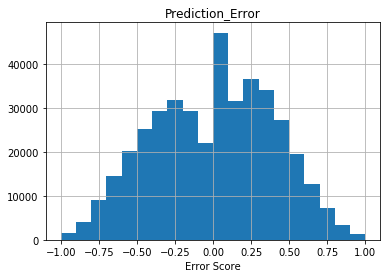

In [125]:
#Error Plot - Histogram

diff = []
for i in range(len(test_set)):
    d = test_set[i][2] - pred_svdpp_test[i][3]
    diff.append(d)
    
diff_df = pd.DataFrame(diff, columns = ['Prediction_Error'])
d_hist = diff_df.hist(bins=20)
plt.xlabel('Error Score')
d_hist

### 7. Recommendation system Latent Factor Model using Keras (Tensorflow Backend)

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, mean_squared_error
import gc
from sklearn import model_selection
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [54]:
n_players = len(all_data['player'].value_counts())
n_games = len(all_data['game'].value_counts())
k = 100   

In [62]:
players_list = set(all_data['player'].values)
games_list = set(all_data['game'].values)

players_df = pd.DataFrame(enumerate(players_list), columns=['player_id', 'player'])
games_df = pd.DataFrame(enumerate(games_list), columns=['game_id', 'game'])

train_data_1 = pd.DataFrame(train_data)
val_data_1   = pd.DataFrame(val_data)
test_data_1  = pd.DataFrame(test_data)

train_data_1 = train_data_1.merge(players_df, on='player')
train_data_1 = train_data_1.merge(games_df, on='game')
val_data_1   = val_data_1.merge(players_df, on='player')
val_data_1   = val_data_1.merge(games_df, on='game')
test_data_1  = test_data_1.merge(players_df, on='player')
test_data_1  = test_data_1.merge(games_df, on='game')

train_data_1.head()

,game,player,score_x,player_id,game_id
0,B6BD-0000-0304-9517,sillyputty2829,1.0,649700,27002
1,B6BD-0000-0304-9517,hiroshi9438,0.0,151388,27002
2,B6BD-0000-0304-9517,cagemaster,0.0,719608,27002
3,B6BD-0000-0304-9517,bentrulock,1.0,823196,27002
4,B6BD-0000-0304-9517,23Juls,0.0,760086,27002


In [57]:
train_data_1 = train_data_1.sample(frac=1).reset_index(drop=True)
val_data_1   = val_data_1.sample(frac=1).reset_index(drop=True)
test_data_1  = test_data_1.sample(frac=1).reset_index(drop=True)

X_p_train = train_data_1['player_id'].values
X_g_train = train_data_1['game_id'].values
y_train   = train_data_1['score_x'].values

X_p_val = val_data_1['player_id'].values
X_g_val = val_data_1['game_id'].values
y_val   = val_data_1['score_x'].values

X_p_test = test_data_1['player_id'].values
X_g_test = test_data_1['game_id'].values
y_test   = test_data_1['score_x'].values

In [64]:
# custom metric - RMSE
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

pl_input = layers.Input((1,))
gm_input = layers.Input((1,))

pl_embedding = layers.Embedding(n_players, k)(pl_input)
gm_embedding = layers.Embedding(n_games, k)(gm_input)

dot_product = layers.Dot(2)([pl_embedding, gm_embedding])
sig_act = layers.Activation('sigmoid')(dot_product)
score_output = layers.Reshape((1,))(sig_act)
c_f_model = models.Model([pl_input, gm_input], score_output)

c_f_model.compile(loss='binary_crossentropy', optimizer='RMSProp', metrics=['acc', rmse])

In [65]:
c_f_model.fit(x=[X_p_train,X_g_train], y=y_train, validation_data=[[X_p_val, X_g_val], y_val], batch_size=32000, epochs=125)

Train on 3270525 samples, validate on 408816 samples
Epoch 1/125
3270525/3270525 [==============================] - 95s 29us/step - loss: 0.6932 - acc: 0.5004 - rmse: 0.5000 - val_loss: 0.6932 - val_acc: 0.4996 - val_rmse: 0.5000
Epoch 2/125
3270525/3270525 [==============================] - 93s 28us/step - loss: 0.6894 - acc: 0.7830 - rmse: 0.4981 - val_loss: 0.6931 - val_acc: 0.5010 - val_rmse: 0.5000
Epoch 3/125
3270525/3270525 [==============================] - 115s 35us/step - loss: 0.6849 - acc: 0.9164 - rmse: 0.4958 - val_loss: 0.6930 - val_acc: 0.5040 - val_rmse: 0.4999
Epoch 4/125
3270525/3270525 [==============================] - 113s 35us/step - loss: 0.6785 - acc: 0.9642 - rmse: 0.4926 - val_loss: 0.6928 - val_acc: 0.5080 - val_rmse: 0.4998
Epoch 5/125
3270525/3270525 [==============================] - 108s 33us/step - loss: 0.6696 - acc: 0.9812 - rmse: 0.4881 - val_loss: 0.6922 - val_acc: 0.5120 - val_rmse: 0.4995
Epoch 6/125
3270525/3270525 [==============================

Epoch 47/125
3270525/3270525 [==============================] - 89s 27us/step - loss: 0.0076 - acc: 1.0000 - rmse: 0.0120 - val_loss: 0.7809 - val_acc: 0.5757 - val_rmse: 0.5121
Epoch 48/125
3270525/3270525 [==============================] - 89s 27us/step - loss: 0.0069 - acc: 1.0000 - rmse: 0.0109 - val_loss: 0.7849 - val_acc: 0.5758 - val_rmse: 0.5127
Epoch 49/125
3270525/3270525 [==============================] - 89s 27us/step - loss: 0.0063 - acc: 1.0000 - rmse: 0.0099 - val_loss: 0.7887 - val_acc: 0.5760 - val_rmse: 0.5133
Epoch 50/125
3270525/3270525 [==============================] - 89s 27us/step - loss: 0.0058 - acc: 1.0000 - rmse: 0.0091 - val_loss: 0.7925 - val_acc: 0.5760 - val_rmse: 0.5139
Epoch 51/125
3270525/3270525 [==============================] - 88s 27us/step - loss: 0.0053 - acc: 1.0000 - rmse: 0.0083 - val_loss: 0.7961 - val_acc: 0.5761 - val_rmse: 0.5144
Epoch 52/125
3270525/3270525 [==============================] - 89s 27us/step - loss: 0.0049 - acc: 1.0000 - r

Epoch 93/125
3270525/3270525 [==============================] - 88s 27us/step - loss: 8.1404e-04 - acc: 1.0000 - rmse: 0.0011 - val_loss: 0.8815 - val_acc: 0.5782 - val_rmse: 0.5254
Epoch 94/125
3270525/3270525 [==============================] - 88s 27us/step - loss: 7.9463e-04 - acc: 1.0000 - rmse: 0.0010 - val_loss: 0.8827 - val_acc: 0.5783 - val_rmse: 0.5256
Epoch 95/125
3270525/3270525 [==============================] - 88s 27us/step - loss: 7.7603e-04 - acc: 1.0000 - rmse: 0.0010 - val_loss: 0.8839 - val_acc: 0.5782 - val_rmse: 0.5257
Epoch 96/125
3270525/3270525 [==============================] - 88s 27us/step - loss: 7.5819e-04 - acc: 1.0000 - rmse: 9.9315e-04 - val_loss: 0.8850 - val_acc: 0.5782 - val_rmse: 0.5258
Epoch 97/125
3270525/3270525 [==============================] - 89s 27us/step - loss: 7.4109e-04 - acc: 1.0000 - rmse: 9.6988e-04 - val_loss: 0.8861 - val_acc: 0.5783 - val_rmse: 0.5259
Epoch 98/125
3270525/3270525 [==============================] - 88s 27us/step - lo

In [127]:
test_pred = c_f_model.predict(x=[X_p_val, X_g_val], verbose=1, batch_size=4096)

RMSE = np.sqrt(mean_squared_error(y_val, test_pred))
print('Root Mean Squared Error (RMSE) on test data : {0:5.4f}'.format(RMSE))

408816/408816 [==============================] - 1s 2us/step
Root Mean Squared Error (RMSE) on test data : 0.5287


### 8. Making Recommendations 

Predictions !!

In [118]:
import random 

player_ids = random.sample(range(n_players), 5)

recommendations = dict()

game_list = list(range(n_games))

for player in player_ids:
    player_list = [player]*n_games
    scores = c_f_model.predict(x=[player_list, game_list], verbose=1)
    temp_df = games_df.copy()
    temp_df['score_x'] = scores
    temp2_df = all_data[all_data['player'] == players_df.loc[player, 'player']]
    temp_df = temp_df.merge(temp2_df, how='left', on='game')
    temp_df = temp_df[temp_df['score_x_y']!=0]
    temp_df = temp_df[temp_df['score_x_y']!=1]
    temp_df.sort_values(by='score_x_x', axis=0, ascending=False, inplace=True)
    temp_df.reset_index(drop=True, inplace=True)
    lst = []

    for m in range(5):
        lst.append([temp_df.loc[m, 'game'], temp_df.loc[m, 'score_x_x']])
        recommendations[players_df.loc[player, 'player']] = lst

print('\n\n')
for player in recommendations.keys():
    print('-------------------------------------------------------------------------------------------------------------------------------------')
    print('Player: {}'.format(player))
    print('Top-5 Recommended games with probability of clearing:')
    print(recommendations[player])

115032/115032 [==============================] - 1s 6us/step



-------------------------------------------------------------------------------------------------------------------------------------
Player: AnimateCorpse
Top-5 Recommended games with probability of clearing:
[['7410-0000-0364-AFCB', 0.9983039], ['7062-0000-0302-FD6F', 0.9979693], ['1F40-0000-032E-FA61', 0.99760604], ['C3F6-0000-0351-6289', 0.9970112], ['1D4D-0000-0354-2B03', 0.9965179]]
-------------------------------------------------------------------------------------------------------------------------------------
Player: hayatotibi
Top-5 Recommended games with probability of clearing:
[['8A4C-0000-0300-31F2', 0.99961215], ['FD60-0000-0342-AE39', 0.9995788], ['DA76-0000-0330-0E93', 0.9995389], ['E3BA-0000-034E-9813', 0.999368], ['C22E-0000-035C-33EE', 0.99933213]]
-------------------------------------------------------------------------------------------------------------------------------------
Player: ravelomananar